## Introduction

This notebook will be about implementing a character-level long short-term memory (LSTM) recurrent neural network (RNN) to generate text using PyTorch. The model will be trained on the text of Shakespeare's plays and will be able to generate text in the style of Shakespeare.

I will only be using PyTorch to define the tensor operations and the neural network architecture. I will not be using any pre-built RNN modules from PyTorch. This is to understand the inner workings of an RNN better.


## Imports


In [1]:
import os
import sys
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from rich import print
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%load_ext rich

# Set random seed for reproducibility
seed = 42

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Set data directory
DATA_DIR = os.path.join(os.getcwd(), "data")

Device: cuda

## Load the dataset

The dataset is a text file containing the text of Shakespeare's plays in `input.txt`. We will load the text file, and see the first few characters of the text.


In [2]:
with open("./input.txt") as f:
    text = f.read()

print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

Now, let's turn this into a dataset that we can use to train the model. To do this, we will need to do preprocessing so the model can understand the text.


In [3]:
class ShakespeareDataset(Dataset):
    """
    A custom Dataset class for Shakespeare text data.

    Attributes:
        text (str): The entire text from the file.
        chars (List[str]): A sorted list of unique characters in the text.
        vocab_size (int): The size of the vocabulary.
        s_to_i (Dict[str, int]): A dictionary mapping characters to indices.
        i_to_s (Dict[int, str]): A dictionary mapping indices to characters.
        seq_len (int): The length of the sequences.
    """

    def __init__(self, file_path: str, seq_len: int):
        """
        Initializes the ShakespeareDataset with the given file path and sequence length.

        Args:
            file_path (str): Path to the text file.
            seq_len (int): Length of the sequences.
        """
        with open(file_path, encoding="utf-8") as f:
            text = f.read()

        self.text = text
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.s_to_i = {s: i for i, s in enumerate(self.chars)}
        self.i_to_s = {i: s for i, s in enumerate(self.chars)}
        self.seq_len = seq_len

    def __len__(self) -> int:
        """
        Returns the length of the dataset.

        Returns:
            int: The number of sequences in the dataset.
        """
        return len(self.text) - self.seq_len

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of input and target sequences for the given index.

        Args:
            idx (int): Index of the sequence.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Input and target sequences as tensors.
        """
        return (
            torch.tensor(
                [self.s_to_i[c] for c in self.text[idx : idx + self.seq_len]],
                dtype=torch.long,
            ),
            torch.tensor(
                [self.s_to_i[c] for c in self.text[idx + 1 : idx + self.seq_len + 1]],
                dtype=torch.long,
            ),
        )

    def decode(self, x: Union[torch.Tensor, List[int]]) -> str:
        """
        Decodes a tensor or list of indices back to a string.

        Args:
            x (Union[torch.Tensor, List[int]]): Tensor or list of indices.

        Returns:
            str: Decoded string.
        """
        if isinstance(x, torch.Tensor):
            x = x.tolist()

        return "".join([self.i_to_s[i] for i in x])

    def encode(self, s: str) -> torch.Tensor:
        """
        Encodes a string into a tensor of indices.

        Args:
            s (str): Input string.

        Returns:
            torch.Tensor: Encoded tensor of indices.
        """
        encoded = [self.s_to_i[c] for c in s]
        return torch.tensor(encoded, dtype=torch.long).to(device)

    def collate_fn(
        self, batch: List[Tuple[torch.Tensor, torch.Tensor]]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Collates a batch of sequences into padded tensors.

        Args:
            batch (List[Tuple[torch.Tensor, torch.Tensor]]): Batch of input and target sequences.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Padded input and target sequences.
        """
        x, y = zip(*batch)
        x = torch.nn.utils.rnn.pad_sequence(
            x, batch_first=True, padding_value=self.s_to_i[" "]
        )
        y = torch.nn.utils.rnn.pad_sequence(
            y, batch_first=True, padding_value=self.s_to_i[" "]
        )
        return x, y

    def get_vocab_size(self) -> int:
        """
        Returns the size of the vocabulary.

        Returns:
            int: Vocabulary size.
        """
        return self.vocab_size

##### What's important above?

- `s_to_i` and `i_to_s` are dictionaries that map characters to integers and integers to characters, respectively. This is important because the model can only understand numbers, so we need to convert the text to numbers. This is a form of tokenization. In a more realistic scenario, we would use a [Byte Pair Encoding (BPE) tokenizer](https://huggingface.co/learn/nlp-course/en/chapter6/5). Karpathy has a great tutorial on how to build this from scratch in one of his amazing videos, [link here.](https://www.youtube.com/watch?v=zduSFxRajkE)
- X and y are the input and output sequences, respectively. The input sequence is a sequence of characters, and the output sequence is the next character in the text. The model will learn to predict the next character in the text given the input sequence.
- `decode` and `encode` are utility functions that convert between representations, mostly for debugging and visualization purposes.
- `collate_fn` creates batches of data to use. See this [StackOverflow answer](https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders) for more information on what `collate_fn` does.


In [4]:
s = ShakespeareDataset("./input.txt", 8)

However, just to make it fun, I'll re-implement everything without the `DataLoader` class.


In [5]:
n = int(len(s) * 0.9)
train_data = s.text[:n]
val_data = s.text[n:]

print(f"Train data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")

Train data: 1003847

Validation data: 111547

In [6]:
# Model parameters
BATCH_SIZE = 4
SEQ_LEN = 8
VOCAB_SIZE = s.get_vocab_size()
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 3

In [7]:
def get_batch(split, BATCH_SIZE, SEQ_LEN):
    data = train_data if split == "train" else val_data

    if split == "train":
        indices = torch.randperm(len(data) - SEQ_LEN)
    else:
        indices = torch.arange(0, len(data) - SEQ_LEN)

    num_batches = (len(data) - SEQ_LEN) // SEQ_LEN

    for i in range(0, num_batches * SEQ_LEN, BATCH_SIZE * SEQ_LEN):
        X = []
        y = []

        for j in indices[i : i + BATCH_SIZE * SEQ_LEN : SEQ_LEN]:
            X.append([s.s_to_i[c] for c in data[j : j + SEQ_LEN]])
            y.append([s.s_to_i[c] for c in data[j + 1 : j + SEQ_LEN + 1]])

        # Convert lists to tensors
        X_tensor = torch.tensor(X, dtype=torch.long)
        y_tensor = torch.tensor(y, dtype=torch.long)

        # Padding sequences if necessary (optional here since all sequences are of the same length)
        X_padded = torch.nn.utils.rnn.pad_sequence(
            X_tensor, batch_first=True, padding_value=s.s_to_i[" "]
        )
        y_padded = torch.nn.utils.rnn.pad_sequence(
            y_tensor, batch_first=True, padding_value=s.s_to_i[" "]
        )

        yield X_padded, y_padded


xb, yb = next(get_batch("train", BATCH_SIZE, SEQ_LEN))

print(xb)
print(yb)

tensor([[43, 56,  8,  0,  0, 32, 30, 13],
        [ 8,  0, 21,  1, 57, 39, 61,  1],
        [43,  1, 40, 39, 52, 47, 57, 46],
        [39, 41, 43,  1, 57, 46, 53, 59]])

tensor([[56,  8,  0,  0, 32, 30, 13, 26],
        [ 0, 21,  1, 57, 39, 61,  1, 46],
        [ 1, 40, 39, 52, 47, 57, 46,  5],
        [41, 43,  1, 57, 46, 53, 59, 50]])

In [8]:
for b in range(BATCH_SIZE):
    for t in range(SEQ_LEN):
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"Context: {context} , Target: {target}")
        print(
            f"Context: {s.decode(context.tolist())} , Target: {s.decode([int(target)])}"
        )

    break

Context: tensor([43]) , Target: 56

Context: e , Target: r

Context: tensor([43, 56]) , Target: 8

Context: er , Target: .

Context: tensor([43, 56,  8]) , Target: 0

Context: er. , Target:

Context: tensor([43, 56,  8,  0]) , Target: 0

Context: er.
 , Target:

Context: tensor([43, 56,  8,  0,  0]) , Target: 32

Context: er.

 , Target: T

Context: tensor([43, 56,  8,  0,  0, 32]) , Target: 30

Context: er.

T , Target: R

Context: tensor([43, 56,  8,  0,  0, 32, 30]) , Target: 13

Context: er.

TR , Target: A

Context: tensor([43, 56,  8,  0,  0, 32, 30, 13]) , Target: 26

Context: er.

TRA , Target: N

## But first, embeddings

Before we train the LSTM model, we first need to create embeddings for the characters. This just means that instead of having a single number represent each character, we will have a vector of numbers represent each character, which will allow the model to learn more complex relationships between characters. To learn more about embeddings, see [this post](https://jalammar.github.io/illustrated-word2vec/) by Jay Alammar.

The math behind embeddings is simple: For each token in the batch, we use an embedding layer to map the token index to a dense vector of size `embedding_dim`.

The input tensor of shape `(batch_size, seq_len)` is transformed into an output tensor of shape `(batch_size, seq_len, embedding_dim)` by looking up the embedding vector for each token index in the input tensor.


In [168]:
class Embedding(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        """
        Initializes the Embedding layer.

        Inputs:
        - vocab_size: The size of the vocabulary.
        - embedding_dim: The dimension of the embedding.

        """

        super().__init__()
        self.W_E = nn.Parameter(torch.empty(vocab_size, embedding_dim))

        # Initialize weights using the Xavier uniform method
        nn.init.xavier_uniform_(self.W_E)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
        - tokens: (B, T)

        Outputs:
        - out: (B, T, EMBEDDING_DIM)
        """

        return self.W_E[tokens]

In [10]:
print(xb.shape, Embedding(VOCAB_SIZE, EMBEDDING_DIM)(xb.to("cpu")).shape)
print(xb[0][0], Embedding(VOCAB_SIZE, EMBEDDING_DIM)(xb[0][0].to("cpu")))

torch.Size([4, 8])
torch.Size([4, 8, 128])

tensor(43) tensor([-6.0070e-02,  7.7341e-02, -8.5825e-02,  3.5511e-02, -5.4409e-02,
         1.4489e-01,  9.2045e-02,  1.2463e-01, -4.9428e-03, -1.1026e-01,
         1.0171e-01, -5.6917e-02, -8.8456e-02, -5.5210e-02,  1.4667e-01,
         3.0358e-02, -8.7270e-03, -5.8606e-02,  6.1084e-02,  1.7107e-01,
        -9.6466e-02, -1.6071e-01,  6.0969e-02, -9.8324e-02, -1.2026e-01,
         1.4316e-01,  1.6416e-01,  2.4593e-02, -1.6501e-01, -1.4086e-01,
         5.5250e-02, -4.8509e-02, -5.2345e-02,  3.1409e-02, -1.7332e-01,
        -8.5196e-02,  6.0085e-02, -1.0865e-01,  1.0858e-01, -1.0556e-02,
         1.4045e-01,  6.6926e-02, -1.1349e-01,  4.4449e-02,  1.5260e-01,
        -1.3297e-01, -4.5423e-02,  1.5769e-01, -1.1576e-01, -9.8897e-02,
         9.1716e-02,  1.3094e-01,  1.2820e-01,  1.4484e-05,  6.1756e-02,
        -4.1275e-02, -1.4464e-01, -1.6395e-01,  1.3485e-01,  1.0355e-01,
         7.0035e-06,  4.2146e-02,  1.1843e-01, -5.3023e-02, -1.0603e-01,
        -5.0536e-02,  1.7559e-01,  1.3874e-01,  1.2007e-01,  1.0386e-01,
         3.8286e-02,  1.7563e-02,  1.3911e-02, -2.8195e-02, -7.3605e-02,
         1.6994e-01,  3.9247e-02, -1.5918e-02, -5.9804e-02, -1.1807e-02,
        -6.8609e-02, -4.8084e-02, -1.6483e-01, -1.5936e-01,  4.8241e-02,
        -1.5638e-01,  4.8716e-02, -1.1908e-01,  1.7065e-01, -9.0028e-02,
        -1.5567e-01,  2.5819e-02,  1.4630e-01,  1.1804e-01,  3.8598e-02,
        -1.6170e-02,  5.1999e-02,  1.2239e-01,  5.0401e-02, -9.5374e-02,
         9.7857e-02, -5.3430e-02, -1.7223e-02, -5.0546e-03, -3.5515e-02,
         1.2804e-01, -1.0463e-01, -9.9744e-02, -1.5149e-02, -1.1789e-01,
         3.4420e-02, -5.6857e-02,  9.0908e-02,  7.0825e-02,  2.2304e-02,
         1.0786e-02,  1.7464e-01,  1.6210e-02,  4.5844e-02,  1.2014e-01,
        -1.7494e-01, -5.0291e-02, -1.3917e-02,  1.1200e-01,  1.1653e-01,
         1.3829e-01,  6.8509e-03, -1.0432e-01], grad_fn=<SelectBackward0>)

## Long short-term memory (LSTM)

The LSTM is a Recurrent Neural Network (RNN) architecture that is designed to learn long-term dependencies in sequences. It has a memory cell that can store information over long periods of time. The LSTM has three gates: the input gate, the forget gate, and the output gate. The input gate controls how much of the new input should be added to the memory cell, the forget gate controls how much of the memory cell should be forgotten, and the output gate controls how much of the memory cell should be outputted.


In [11]:
class LSTMCell(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int):
        """
        Initializes the LSTM cell.

        Inputs:
        - embedding_dim: The dimension of the input embeddings.
        - hidden_dim: The dimension of the hidden state.

        """
        super().__init__()
        self.hidden_dim = hidden_dim

        self.W_f = nn.Parameter(torch.empty(embedding_dim + hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_i = nn.Parameter(torch.empty(embedding_dim + hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.empty(embedding_dim + hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.W_g = nn.Parameter(torch.empty(embedding_dim + hidden_dim, hidden_dim))
        self.b_g = nn.Parameter(torch.zeros(hidden_dim))

        # Initialize weights using the Xavier uniform initialization
        nn.init.xavier_uniform_(self.W_f)
        nn.init.xavier_uniform_(self.W_i)
        nn.init.xavier_uniform_(self.W_o)
        nn.init.xavier_uniform_(self.W_g)

    def forward(
        self, x: torch.Tensor, h: torch.Tensor, c: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """

        Inputs:
        - x: (B, SEQ_LEN, EMBEDDING_DIM) - input at the current time step
        - h: (B, HIDDEN_DIM) - hidden state from the previous time step
        - c: (B, HIDDEN_DIM) - cell state from the previous time step

        Outputs:
        - hidden_seq: (B, SEQ_LEN, HIDDEN_DIM) - hidden states for all time steps in the sequence
        - (h, c): (B, HIDDEN_DIM) - hidden state and cell state for the last time step in the sequence

        """

        B, SEQ_LEN, EMBEDDING_DIM = x.shape
        hidden_seq = []

        for t in range(SEQ_LEN):
            x_t = x[:, t, :]

            combined = torch.cat((x_t, h), dim=1)

            f = torch.sigmoid(torch.mm(combined, self.W_f) + self.b_f)
            i = torch.sigmoid(torch.mm(combined, self.W_i) + self.b_i)
            o = torch.sigmoid(torch.mm(combined, self.W_o) + self.b_o)

            g = torch.tanh(torch.mm(combined, self.W_g) + self.b_g)

            c = f * c + i * g
            h = o * torch.tanh(c)

            hidden_seq.append(h.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h, c)

### Breaking it down

There's two key ideas in the LSTM / RNN architecture, namely sequential processing and the hidden state.

#### Sequential processing

This is the fundamental idea behind RNNs. The model processes the input sequence one token at a time, and maintains a hidden state that is updated at each time step. The hidden state is used to maintain information about the sequence that the model has seen so far. This is the reason we created those sequences of `X` and `y` earlier.

In the forward pass, we loop over the input sequence, and at each time step, we pass the input token, along with the hidden state from the previous time step through the various gates of the LSTM cell to get the output token and the updated hidden state.

#### Hidden state

The hidden state in a RNN-arhitecture is a vector that acts as a memory for the model. What makes LSTMs so performant is that it implements two versions of the memory, namely the short-term memory (what the model is currently looking at, $h_t$) and the long-term memory (what the model has seen so far or the cell state, $c_t$).

The gates in the LSTM cell control the flow of information in the computational graph. Through this, each cell can interpolate between the short-term and long-term memory, and decide what information to keep and what to discard. Let's look at the gates:

- **Forget gate:** This gate decides what information to keep and what to discard from the long-term memory. It takes the input token ($x_t$) and the hidden state from the previous time step ($h_{t-1}$) as input, and outputs a vector of values between 0 and 1 that are used to scale the long-term memory, essentially deciding what to forget (close to 0) and what to keep (close to 1).
- **Input gate:** This gate combines information from the input token and $h_{t-1}$ and decides what new information to add to the long-term memory. Here, the input token is passed through a sigmoid function to decide what to add to the long-term memory, and a tanh function to decide what to add.
- **Output gate:** This gate decides what information to take from the long-term memory and pass to the short-term memory. The output gate also takes $x_t$ and $h_{t-1}$ as input and outputs a vector to scale the long-term memory's contribution to the short-term memory.

##### The equations

Mathematically, the flow of an LSTM cell can be described as follows:

$$
\begin{align}
f_t &= \sigma(W_f \cdot [x_t, h_{t-1}] + b_f) \\
i_t &= \sigma(W_i \cdot [x_t, h_{t-1}] + b_i) \\
o_t &= \sigma(W_o \cdot [x_t, h_{t-1}] + b_o) \\
g_t &= \tanh(W_g \cdot [x_t, h_{t-1}] + b_g) \\
\\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \tanh(c_t)
\end{align}
$$

The $\odot$ operator denotes element-wise or point-wise multiplication. The $W$ and $b$ are the weights and biases of the LSTM cell, respectively. The $[x_t, h_{t-1}]$ notation denotes the concatenation of the input token and the hidden state from the previous time step.


In [12]:
LSTMCell(EMBEDDING_DIM, HIDDEN_DIM).forward(
    Embedding(VOCAB_SIZE, EMBEDDING_DIM)(xb.to("cpu")),
    torch.zeros(BATCH_SIZE, HIDDEN_DIM),
    torch.zeros(BATCH_SIZE, HIDDEN_DIM),
)[0].shape

torch.Size([4, 8, 256])

### Multi-layer LSTM

The above equations describe a single-layer LSTM cell. In practice, you can stack multiple LSTM cells on top of each other to create a multi-layer LSTM. The output of the LSTM cell at each layer is passed as input to the LSTM cell at the next layer. This allows the model to learn more complex relationships in the data.

In order to implement this, we will need to tweak the `LSTMCell` class to only operate on a single layer, and then create a `LSTM` class that loops over the input sequence and passes the input tokens through the LSTM cells at all layers. To make the processing faster, I'll stack the weights of the gates into a single matrix, and the biases into a single vector. Additionally, we will also add a dropout layer to the LSTM cell to prevent overfitting.


In [107]:
class LSTMCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Initializes the LSTM cell with input and hidden dimensions.

        Inputs:
        - input_dim: The dimension of the input.
        - hidden_dim: The dimension of the hidden state.

        """

        super().__init__()
        self.hidden_dim = hidden_dim

        self.W_x = nn.Parameter(torch.empty(input_dim, 4 * hidden_dim))
        self.W_h = nn.Parameter(torch.empty(hidden_dim, 4 * hidden_dim))
        self.b = nn.Parameter(torch.zeros(4 * hidden_dim))

        # Initialize weights using the Xavier uniform initialization
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / np.sqrt(self.hidden_dim)

        for weight in self.parameters():
            if weight.dim() > 1:
                nn.init.uniform_(weight, -stdv, stdv)

    def forward(
        self, x: torch.Tensor, hidden: Tuple[torch.Tensor, torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """

        Inputs:
        - x: (B, SEQ_LEN, EMBEDDING_DIM) - input at the current time step
        - hc: ((B, HIDDEN_DIM), (B, HIDDEN_DIM)) - tuple containing hidden state and cell state from the previous time step

        Outputs:
        - hidden_seq: (B, SEQ_LEN, HIDDEN_DIM) - hidden states for all time steps in the sequence
        - hidden: ((B, HIDDEN_DIM), (B, HIDDEN_DIM)) - hidden state and cell state for the last time step in the sequence
        """

        B, SEQ_LEN, EMBEDDING_DIM = x.shape

        if hidden is None:
            h, c = self.init_hidden(B)

        else:
            h, c = hidden

        hidden_seq = []

        for t in range(SEQ_LEN):
            x_t = x[:, t, :]

            gates = torch.matmul(x_t, self.W_x) + torch.matmul(h, self.W_h) + self.b

            i = torch.sigmoid(gates[:, : self.hidden_dim])
            f = torch.sigmoid(gates[:, self.hidden_dim : 2 * self.hidden_dim])
            o = torch.sigmoid(gates[:, 2 * self.hidden_dim : 3 * self.hidden_dim])
            g = torch.tanh(gates[:, 3 * self.hidden_dim :])

            c = f * c + i * g
            h = o * torch.tanh(c)

            hidden_seq.append(h.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)

        return hidden_seq, (h, c)

    def init_hidden(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.zeros(batch_size, self.hidden_dim).to(device),
            torch.zeros(batch_size, self.hidden_dim).to(device),
        )

In [129]:
class LSTM(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float = 0.0
    ):
        """
        Initializes the LSTM with input and hidden dimensions, number of layers, and dropout. The number of layers determines the number of LSTM cells in the network.

        Inputs:
        - input_dim: The dimension of the input.
        - hidden_dim: The dimension of the hidden state.
        - num_layers: The number of LSTM cells in the network.
        - dropout: The dropout probability.
        """

        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Create a list of LSTM cells
        self.layers = nn.ModuleList(
            [
                LSTMCell(input_dim, hidden_dim),
                *[LSTMCell(hidden_dim, hidden_dim) for i in range(num_layers - 1)],
            ]
        )

    def forward(
        self, x: torch.Tensor, hidden: Tuple[torch.Tensor, torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Inputs:
        - x: (B, SEQ_LEN, EMBEDDING_DIM) - input sequence
        - hidden: List of tuples containing hidden and cell states for each LSTM layer
        Outputs:
        - hidden_seq: (B, SEQ_LEN, HIDDEN_DIM) - hidden states for all time steps
        - hidden: List of tuples containing hidden and cell states for each LSTM layer
        """

        if hidden is None:
            hidden = [None] * self.num_layers

        input_seq = x
        new_hidden = []

        for i, layer in enumerate(self.layers):
            input_seq, hc = layer(input_seq, hidden[i])
            new_hidden.append(hc)

        input_seq = F.dropout(input_seq, p=self.dropout, training=self.training)

        return input_seq, new_hidden


This is a 16-layer LSTM with a dropout of 0.2, which means that there are 16 LSTM cells in the model, each with a hidden dimension of 256. The dropout layer is applied after each LSTM cell with a probability of 0.2.


In [130]:
LSTM(EMBEDDING_DIM, HIDDEN_DIM, 16, 0.2).to(device).forward(
    Embedding(VOCAB_SIZE, EMBEDDING_DIM).to(device)(xb),
)[0].shape

torch.Size([4, 8, 256])

## Fully-connected layer

Finally, we need to add a fully-connected layer to the model to map the output of the LSTM cell to the vocabulary size. Within the LSTM layer, neurons are connected to each other in a sequence, but the fully-connected layer connects all the input neurons to all the output neurons. This is probably the simplest layer in the model, and it is used to map the output of the LSTM cell to the vocabulary size, which is the number of unique characters in the text.


In [131]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        Initializes the fully connected layer to transform the hidden state to the output. The output size is equal to the vocabulary size.

        Inputs:
        - in_features: The size of the input.
        - out_features: The size of the output.
        """

        super().__init__()
        self.W = nn.Parameter(torch.empty(in_features, out_features))
        self.b = nn.Parameter(torch.zeros(out_features))

        # Initialize weights using the Xavier uniform initialization
        nn.init.xavier_uniform_(self.W)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.W) + self.b

In [132]:
out, _ = (
    LSTMCell(EMBEDDING_DIM, HIDDEN_DIM)
    .to(device)
    .forward(
        Embedding(VOCAB_SIZE, EMBEDDING_DIM).to(device)(xb),
    )
)

logits = Linear(HIDDEN_DIM, VOCAB_SIZE).to(device).forward(out)
preds = F.log_softmax(logits[:, -1], dim=1)

for i in range(BATCH_SIZE):
    print(f"Input {i}: {s.decode(xb[i].tolist())}")
    print(f"Output {i}: {s.decode([torch.argmax(preds, dim=1)[i].item()])}")

Input 0: Leave me

Output 0: t

Input 1: a surgeo

Output 1: s

Input 2: e thy tu

Output 2: ,

Input 3: greet hi

Output 3: -

We take the last hidden state of the LSTM cell and pass it through the fully-connected layer to get the output logits. The logits are then passed through a softmax layer to get the probability distribution over the vocabulary, which is used to predict the next character in the text.

Of course, the output does not make any sense currently as it is just predicting with randomly initialized weights everytime. However, it would be fun to look at the likelihood of the next character for a given input batch. Let's visualize this. This part is inspired by Karpathy's [blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).


In [133]:
def visualize_predictions(input_batch, logits, s, k=10):
    """
    Visualize the likelihood of the next character for a given input batch.

    Args:
    - input_batch (torch.Tensor): The input batch of shape (BATCH_SIZE, SEQ_LEN).
    - logits (torch.Tensor): The logits of shape (BATCH_SIZE, VOCAB_SIZE).
    - s (ShakespeareDataset): The dataset object for decoding indices to characters.
    - k (int): The number of top predictions to display.
    """
    BATCH_SIZE, SEQ_LEN = input_batch.shape

    fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(5 * BATCH_SIZE, 10))

    for i in range(BATCH_SIZE):
        input_text = s.decode(input_batch[i].tolist())
        last_logits = logits[i, -1]

        topk_probs, topk_indices = torch.topk(last_logits, k)
        topk_chars = [s.chars[idx] for idx in topk_indices]

        sns.heatmap(
            topk_probs.reshape(-1, 1).detach().cpu().numpy(),
            annot=True,
            fmt=".4f",
            yticklabels=topk_chars,
            cbar=False,
            cmap="coolwarm",
            ax=axes[i],
        )

        axes[i].set_title(f"Input: {input_text}")
        axes[i].set_ylabel("Characters")
        axes[i].set_xlabel("Probability")

    plt.tight_layout()
    plt.show()

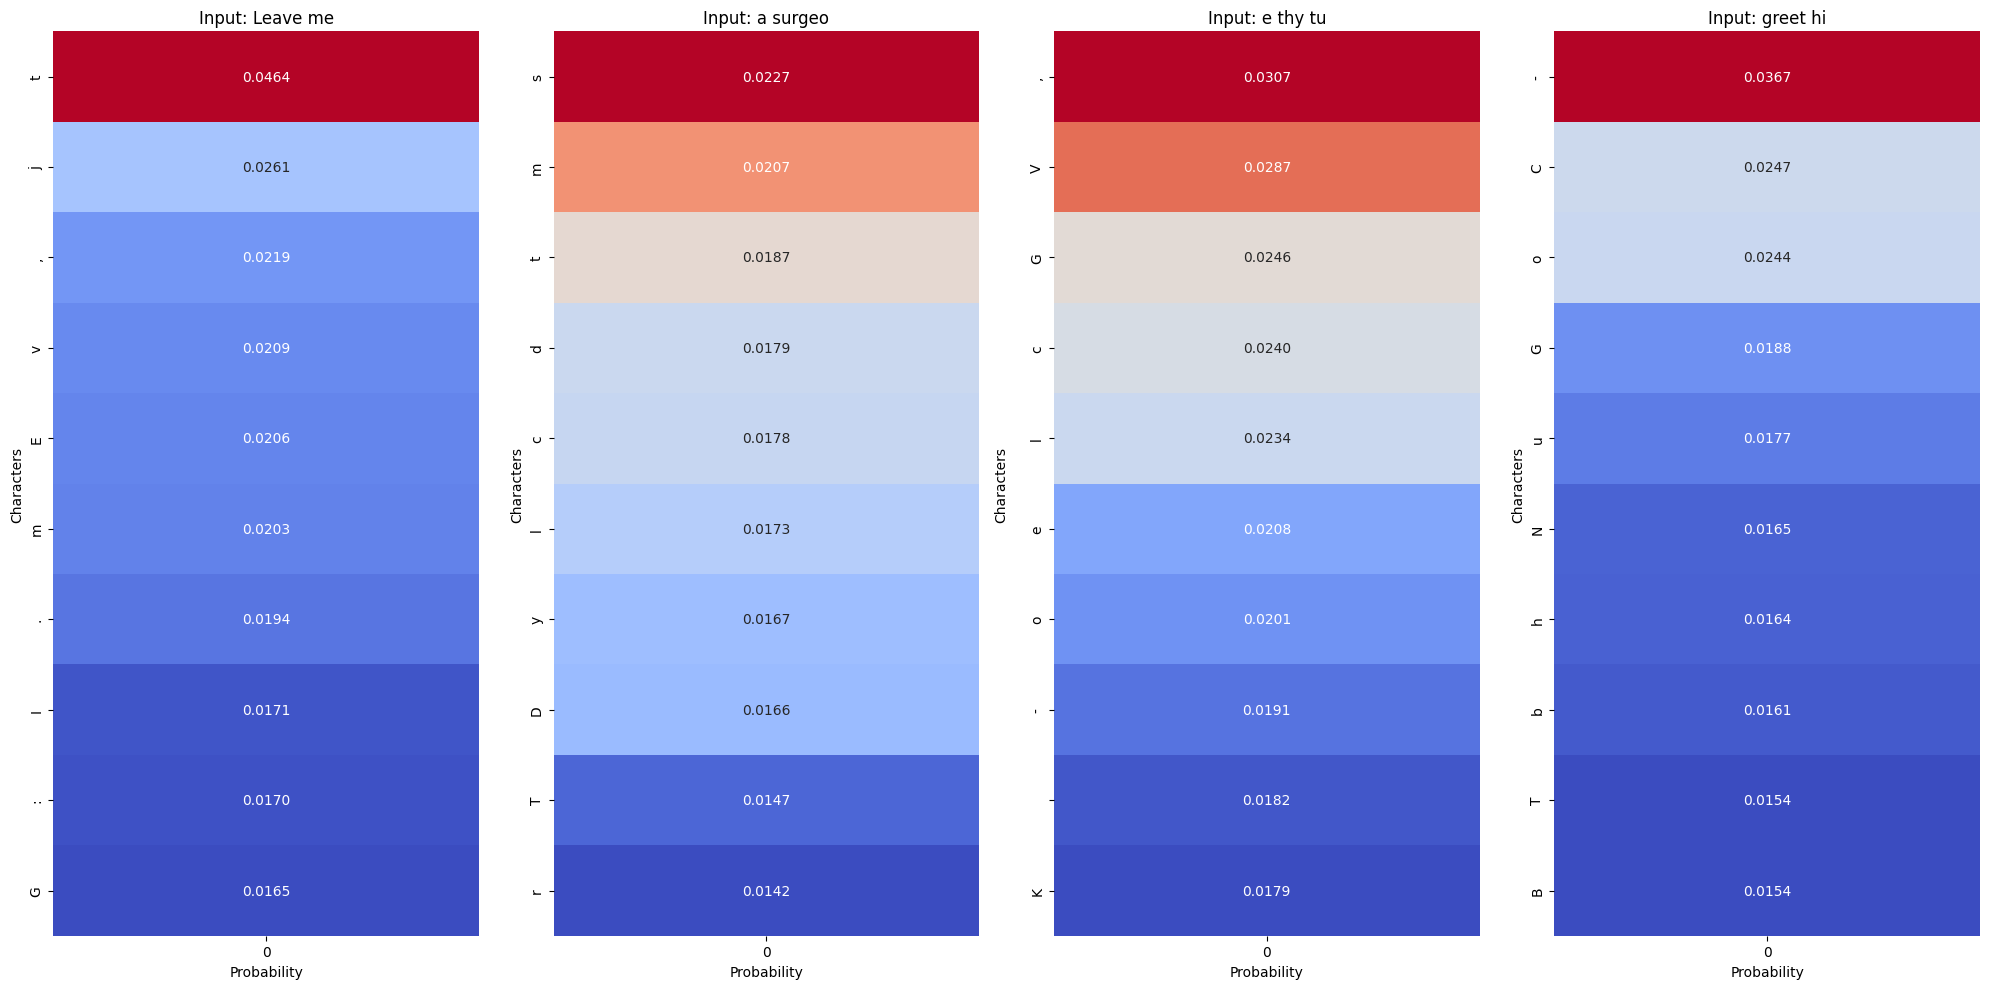

In [134]:
visualize_predictions(xb, logits, s, k=10)

## Connecting the blocks

Now that we have all the components of the model, we can connect them together to create the `ShakespeareModel` class. This class will take the input sequence, pass it through the embedding layer, the LSTM layer, and the fully-connected layer, and return the output logits.


In [169]:
class ShakespeareModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int,
        dropout: float = 0.0,
    ):
        """
        Initializes the ShakespeareModel with the given vocabulary size, 
        embedding dimension, hidden dimension, number of layers, and dropout.

        Inputs:
        - vocab_size: The size of the vocabulary.
        - embedding_dim: The dimension of the input embeddings.
        - hidden_dim: The dimension of the hidden state.
        - num_layers: The number of LSTM cells in the network.
        - dropout: The dropout probability.
        """

        super().__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(
            input_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
        )
        self.linear = Linear(hidden_dim, vocab_size)

        self.to_device(device)

    def forward(
        self, x: torch.Tensor, hidden: Tuple[torch.Tensor, torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.linear(x)

        return x, hidden

    def generate(self, x0: str, n: int = 100, temperature: float = 1.0) -> str:
        """
        Generate text given a starting sequence.

        Args:
        - x0 (str): The starting sequence.
        - n (int): The number of characters to generate.
        - temperature (float): The temperature for sampling.

        Returns:
        - str: The generated text.
        """
        self.eval()

        inputs = s.encode(x0).unsqueeze(0).to(device)
        hidden = None

        output = x0

        for _ in range(n):
            logits, hidden = self.forward(inputs, hidden)
            logits = logits[:, -1, :] / temperature

            probs = F.softmax(logits, dim=-1)

            next_char = torch.multinomial(probs, 1).item()
            output += s.decode([next_char])

            inputs = torch.tensor([[next_char]]).to(device)
            yield s.decode([next_char])

        return output

In [170]:
# Model parameters
BATCH_SIZE = 128
SEQ_LEN = 32
VOCAB_SIZE = s.get_vocab_size()
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 3

In [176]:
model = ShakespeareModel(
    VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, dropout=0.2
).to(device)


chars = model.generate("ROMEO:", n=10, temperature=0.5)
print("ROMEO:", "".join(chars))


ROMEO: RgjeqSUnPi

# Training the model

Now comes the fun part: training the model! We have the model architecture in place, and we have the data ready to go. The next step is to train the model on the data and have it start generating text in the style of Shakespeare. Before we do that, we need to define the loss function and the optimizer.

## Loss function

The loss function is deep learning is a measure of how well the model is performing. The goal of training the model is to minimize the loss function, which means that the model is getting better at generating text in the style of Shakespeare. The loss function we will use is the cross-entropy loss, which is commonly used for classification tasks. The cross-entropy loss measures the difference between the predicted probability distribution and the true probability distribution.

## Optimizer

The optimizer is the algorithm that is used to update the weights of the model during training. The first optimizer I learned about was the stochastic gradient descent (SGD) optimizer, but there are many other optimizers that are more performant, such as Adam, RMSprop, and Adagrad. We will use the AdamW optimizer in this notebook.


In [177]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [178]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [183]:
NUM_EPOCHS = 10
loss_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    num_batches = 0

    for step, (xb, yb) in enumerate(get_batch("train", BATCH_SIZE, SEQ_LEN)):
        xb, yb = xb.to(device), yb.to(device)

        hidden = None

        optimizer.zero_grad()

        logits, hidden = model(xb, hidden)

        if hidden is not None:
            for h in hidden:
                for state in h:
                    state.detach_()

        yb = yb.view(-1)
        logits = logits.view(-1, logits.size(-1))

        loss = criterion(logits, yb)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        train_loss += loss.item()
        num_batches += 1

        if step % 50 == 0:
            inf_out = model.generate("to be or not to be: ", n=100, temperature=0.5)
            print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Loss: {loss.item():.4f}")
            print(f'Inference:\n{"".join(inf_out)}')
            print("-" * 100)

            # Set model back to training mode
            model.train()

    average_loss = train_loss / num_batches
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Average Loss: {average_loss:.4f}")

Epoch 1/10 - Loss: 4.1683

Inference:
YuAquuikENV.yCWKl K:I3ZVO.bo XcS; nefk&XdE:XD?iLn;FleeWcKo u;VFZqkRWKk;MvmxtTYEuDqA;aKrNV,,Tc :fAgth

----------------------------------------------------------------------------------------------------

Epoch 1/10 - Loss: 3.3083

Inference:
m  
   o h lo,rto n s e  oieeee e    g s t  aoei o th e us lee   t e w  eter  rreeteda    t n n  en

----------------------------------------------------------------------------------------------------

Epoch 1/10 - Loss: 2.9860

Inference:
oenst ncorn oou en he eol eue tae hain gnoe hou hia aeu aoe lathae haiy nhe ton ae oae tttte cene io

----------------------------------------------------------------------------------------------------

Epoch 1/10 - Loss: 2.8317

Inference:
too hot te wte fres ty toe hii haue he bon the oo tant mae ee moles ae tot shss cor, hae.


IIAON⭕

----------------------------------------------------------------------------------------------------

Epoch 1/10 - Loss: 2.6788

Inference:
ae yoe le te tot in teae tit oir rercees goloes, shie hht ho io bhut aot eile sare tare ne soas taia

----------------------------------------------------------------------------------------------------

Epoch 1/10 - Average Loss: 3.0035

Epoch 2/10 - Loss: 2.4314

Inference:
mo mose an fhe leot are here sondige tite thipe same fige thit on ae tho sore thom fere the thit ant

----------------------------------------------------------------------------------------------------

Epoch 2/10 - Loss: 2.3685

Inference:
the at the and and mik siod thot dos you the hee hith thit the gort.

OUCDONU
TER
TE
DENUS:
Where th

----------------------------------------------------------------------------------------------------

Epoch 2/10 - Loss: 2.2701

Inference:
thile that and thaud the thom he core, that lond mare as that whith the dather, a proor aftet he thi

----------------------------------------------------------------------------------------------------

Epoch 2/10 - Loss: 2.1594

Inference:
a srood the lider sir the well the kist me and werrens there, what the?

MOMINUNENTAN:
Ho me you kid

----------------------------------------------------------------------------------------------------

Epoch 2/10 - Loss: 2.1403

Inference:
my your furd,
I the being it stonke, and bear more the hith not a martess the I the farded, and the

----------------------------------------------------------------------------------------------------

Epoch 2/10 - Average Loss: 2.2405

Epoch 3/10 - Loss: 2.0727

Inference:
and suy my the mere the cate;
The hill ming the leater see and the peet dear the searster that me an

----------------------------------------------------------------------------------------------------

Epoch 3/10 - Loss: 1.9918

Inference:
and more and mads and the in the custer for and manter of the say mand.

KING VICHERLE:
Whe come of

----------------------------------------------------------------------------------------------------

Epoch 3/10 - Loss: 1.9513

Inference:
the love we come as hit not she word so me the with in the with rester the wath that he with not my

----------------------------------------------------------------------------------------------------

Epoch 3/10 - Loss: 1.9392

Inference:
and be lither son the selven blows and my farther, where hound me preater
And and her stould bear no

----------------------------------------------------------------------------------------------------

Epoch 3/10 - Loss: 1.8342

Inference:
and string the best the rest and this heaved of there's my dore your love.

ROMEO:
Where their not i

----------------------------------------------------------------------------------------------------

Epoch 3/10 - Average Loss: 1.9507

Epoch 4/10 - Loss: 1.8641

Inference:
the have bear her for her monestited.

Sercester:
In hour some dissrestents the will the koues of th

----------------------------------------------------------------------------------------------------

Epoch 4/10 - Loss: 1.8422

Inference:
what do a preat the it the strous the bove man brook not unded me thee,
Nor so place my not the pati

----------------------------------------------------------------------------------------------------

Epoch 4/10 - Loss: 1.8183

Inference:
my seed the kear the tran to the them the broughter of the day not of the most and the dounters, the

----------------------------------------------------------------------------------------------------

Epoch 4/10 - Loss: 1.7263

Inference:
the varlast her speak.

KING EDWARD III:
You may that the master of the in the poor man
That selven

----------------------------------------------------------------------------------------------------

Epoch 4/10 - Loss: 1.7460

Inference:
the prise near hath all the will prose as the bight to a poor to my long,
The canter to me the grown

----------------------------------------------------------------------------------------------------

Epoch 4/10 - Average Loss: 1.7897

Epoch 5/10 - Loss: 1.7169

Inference:
which be the from the lets of the like the king and the colds,
And pray, the not the prople the say

----------------------------------------------------------------------------------------------------

Epoch 5/10 - Loss: 1.7667

Inference:
I be was the lies you and the dead I were the served in the haster, the trate that here me the past

----------------------------------------------------------------------------------------------------

Epoch 5/10 - Loss: 1.6915

Inference:
for this death.

KING RICHARD III:
I would the body may we make to this mane thee to me the mother b

----------------------------------------------------------------------------------------------------

Epoch 5/10 - Loss: 1.6550

Inference:
and it the more that
Stand thee to like as the change and mine can am it me to the bear your man
Tha

----------------------------------------------------------------------------------------------------

Epoch 5/10 - Loss: 1.6261

Inference:
what fair enemies.

GRUTUS:
And that this day for they are a prisience.

LADY ANNE:
A what I am so p

----------------------------------------------------------------------------------------------------

Epoch 5/10 - Average Loss: 1.6858

Epoch 6/10 - Loss: 1.6357

Inference:
but my peace;
He are a garted shall be the dure, do more to bid a can than me to see the seers to th

----------------------------------------------------------------------------------------------------

Epoch 6/10 - Loss: 1.5763

Inference:
sir, the kast thou wast we have them and the father
That this begen the counting of his land of ence

----------------------------------------------------------------------------------------------------

Epoch 6/10 - Loss: 1.6235

Inference:
I such this with me to the present her shall not
Be princes to be not that we for the douse of any a

----------------------------------------------------------------------------------------------------

Epoch 6/10 - Loss: 1.6120

Inference:
thou comest the all of his goodly hope
That you not in the man him of that we should to great to the

----------------------------------------------------------------------------------------------------

Epoch 6/10 - Loss: 1.6166

Inference:
and so thou thee that I take him the news,
The reeps of redeent to be unto me the commssission, let

----------------------------------------------------------------------------------------------------

Epoch 6/10 - Average Loss: 1.6094

Epoch 7/10 - Loss: 1.5707

Inference:
when the provest, the marge the man a father and stand in my sorrow who deviled the hands from him t

----------------------------------------------------------------------------------------------------

Epoch 7/10 - Loss: 1.5397

Inference:
then shall not be prayers his prince,
Thou hast in the thing of some of the comanallion of the man t

----------------------------------------------------------------------------------------------------

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   │                                                                                       │
│   14 │   │   optimizer.zero_grad()                                                               │
│   15 │   │                                                                                       │
│ ❱ 16 │   │   logits, hidden = model(xb, hidden)                                                  │
│   17 │   │                                                                                       │
│   18 │   │   if hidden is not None:                                                              │
│   19 │   │   │   for h in hidden:                                                                │
│                                                                                                  │
│ c:\Users\Lakshya                                                                                 │
│ Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ in forward:44                                                                                    │
│                                                                                                  │
│   41 │   ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:                            │
│   42 │   │   x = self.embedding(x)                                                               │
│   43 │   │   x, hidden = self.lstm(x, hidden)                                                    │
│ ❱ 44 │   │   x = self.linear(x)                                                                  │
│   45 │   │                                                                                       │
│   46 │   │   return x, hidden                                                                    │
│   47                                                                                             │
│                                                                                                  │
│ c:\Users\Lakshya                                                                                 │
│ Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_

With that, the model should start training. Of course, the implementation is quite slow as compared to the PyTorch implementation, primarily because of the lack of vectorization in many places. However, it is a good exercise to understand how the model works under the hood. After a few epochs, let's look at the loss curve and the generated text.


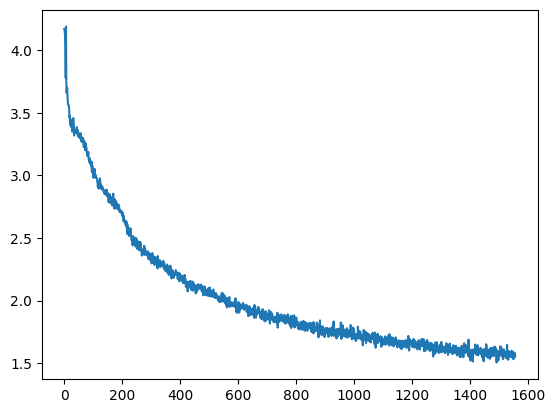

In [184]:
plt.plot(loss_history)

In [185]:
torch.save(model.state_dict(), "model.pth")

# Sampling from the model


In [186]:
model = ShakespeareModel(
    VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, dropout=0.2
).to(device)

model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [188]:
x0 = "ANTONIO:"  # starting sequence

MAX_LEN = 1000

sys.stdout.write(x0)
for char in model.generate(x0, n=MAX_LEN, temperature=0.5):
    sys.stdout.write(char)
    sys.stdout.flush()

ANTONIO:
I will you will of come of Clarence, as a words to was the father can with the auther.

CORIOLANUS:
What is the such with a somethange,
And not for the duke of sir, this is our rest, and then the is the streak of the friends and most soul,
I have to would the forget in this brother command of the was become it be confessed the people arms
And then you sweet part in the country of the world, and stall the comples of her soul and were the lady and before I am come to thee
That heart the follow shall be dead to see the people my father's death,
And prove your reculs of the sharl you be the contents and my lords:
And have in the keal among with the man that have an it with heart.

DUKE VINCENTIO:
Who hast can me so were the strike of the proceacher,
That shall not fair not have so mark thy constants of the sea the sing in a life,
And the shall on the man and in a while we should not will the fair wears to the part and the queen
The earth the call to her be now to the did provise h

With only 1 hour of training, the model has learned to output text in the style of Shakespeare, characterized by prose-like sentences and archaic language. Of course, there are still some mistakes in the text, but those can be fixed with more training and hyperparameter tuning. 


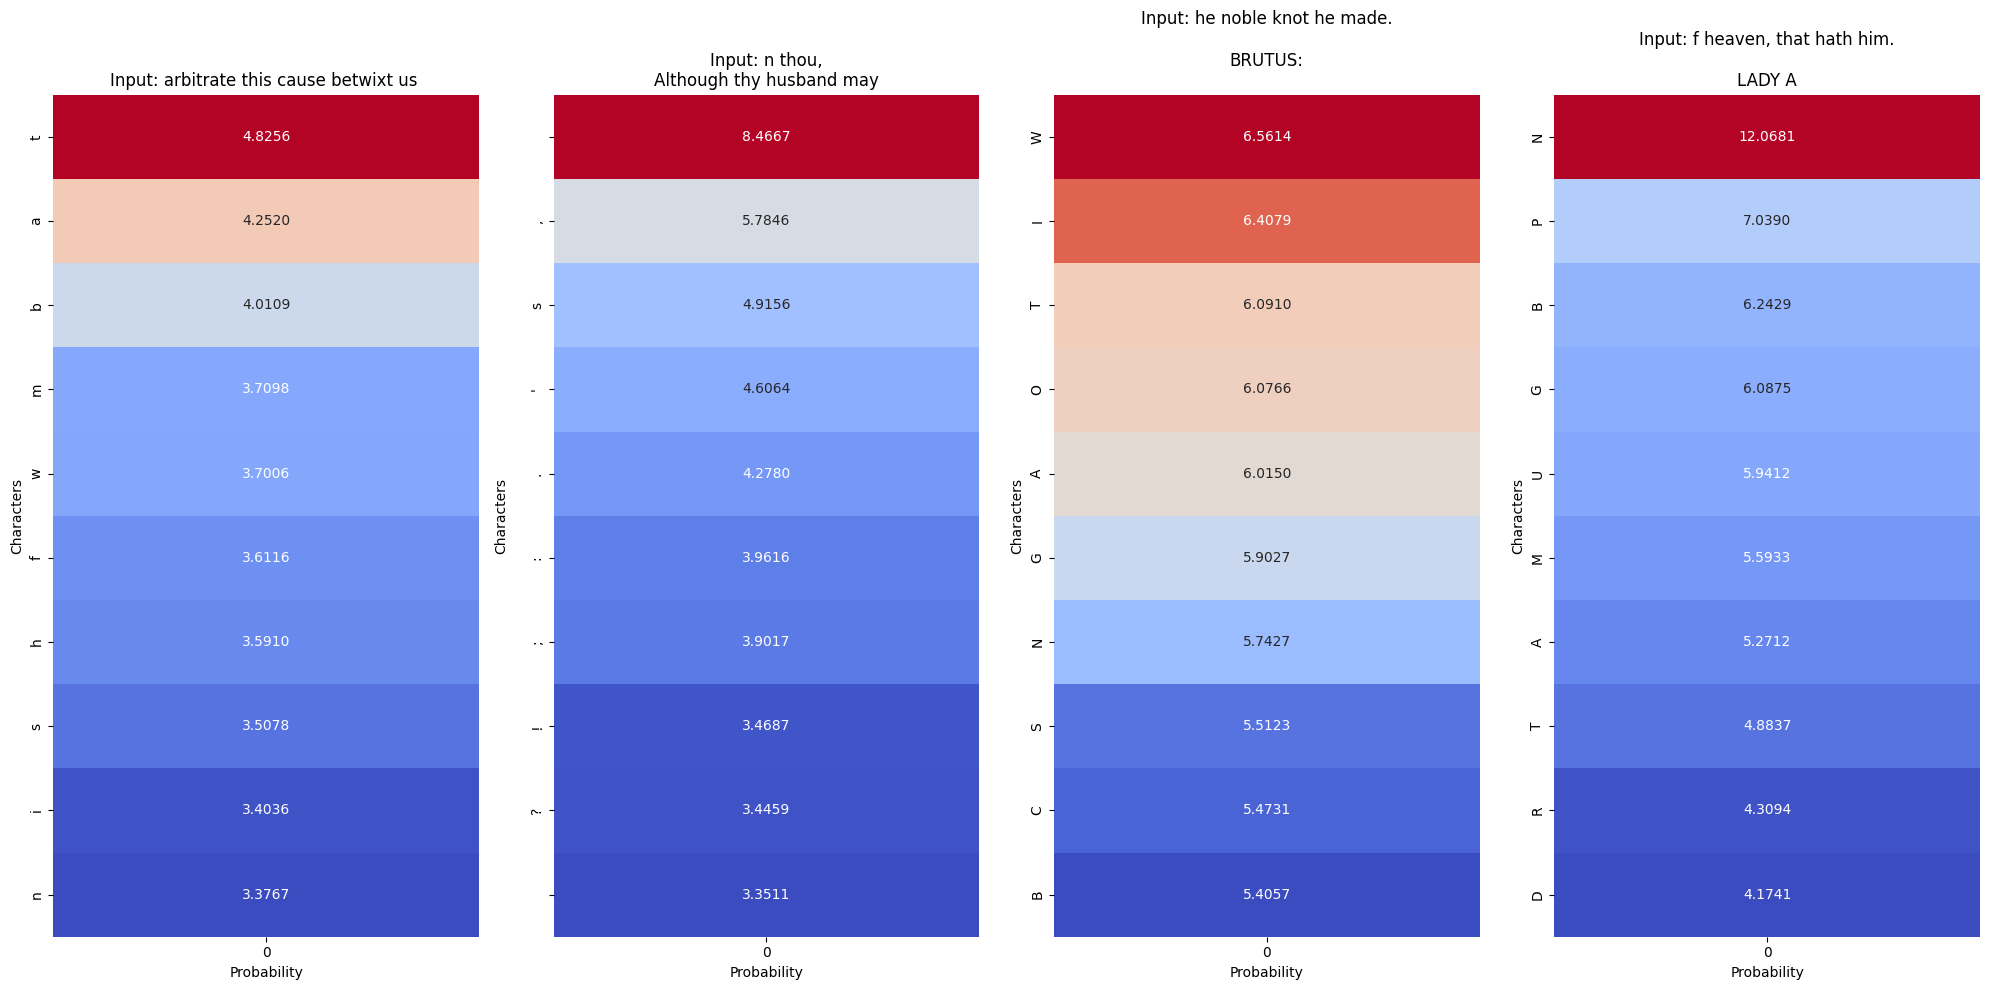

In [155]:
logits, _ = model(xb[:4])

visualize_predictions(xb[:4], logits, s, k=10)